In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import pickle
import restools
from comsdk.research import Research

In [3]:
np.set_printoptions(precision=3, threshold=100, suppress=True)

In [4]:
res = Research.open('RC_MOEHLIS')

Loaded research at C:\Users\ovann\Documents\Researches\2021-04-30-predicting-transition-to-turbulence-using-esn
Number of tasks in the current research: 5059


In [5]:
task_num = 42
data = []
time = []
n_files = 100

for num_data in range(n_files):
    with open(os.path.join(res.get_task_path(task_num), str(num_data+1)), 'rb') as a:
        b = pickle.load(a)
    data.append(b['timeseries'])
    time.append(b['time'])

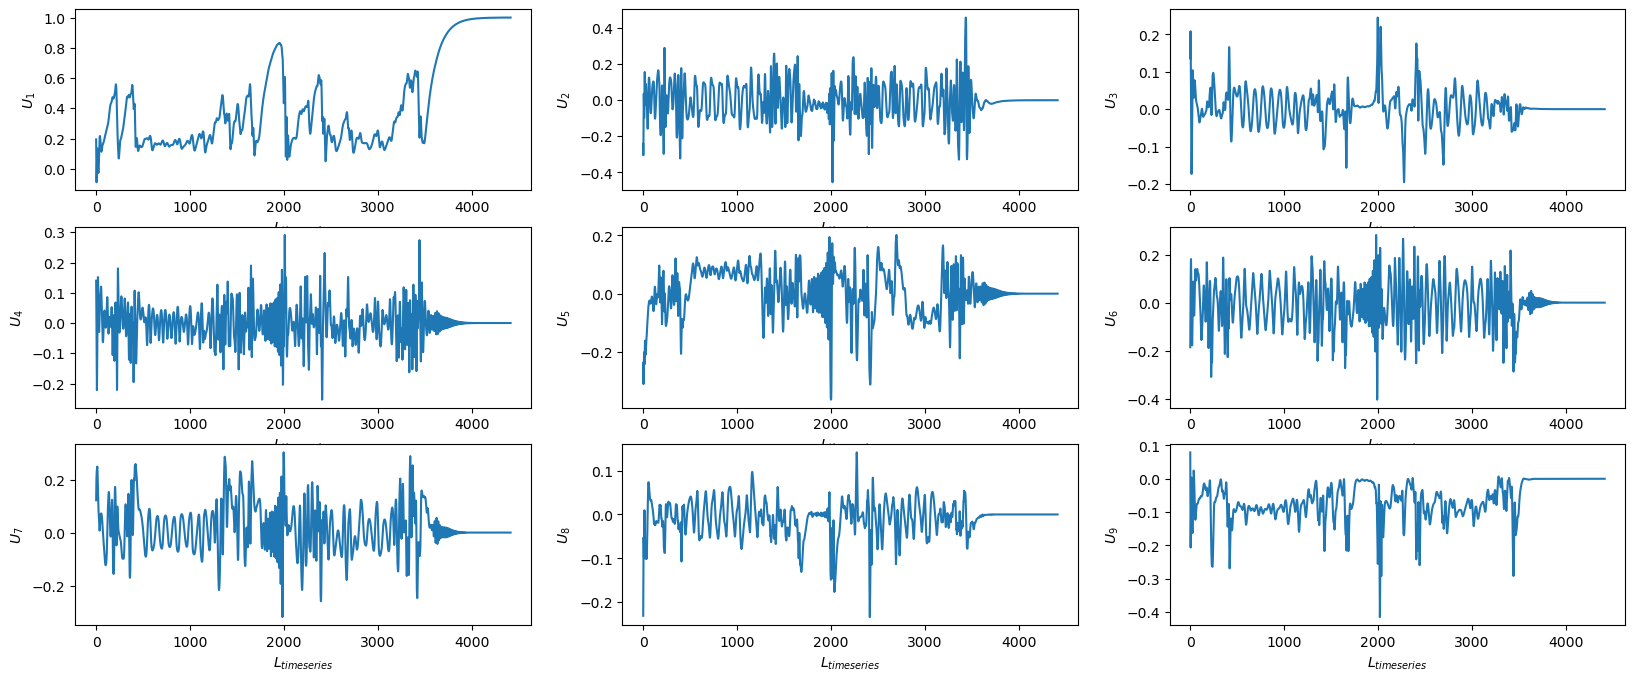

In [6]:
#n_timeseries = 0
n_timeseries = np.argmax(list(map(len, time)))+3

plt.figure(figsize=(20,8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(np.array(data[n_timeseries])[:, i], '-');
    plt.xlabel(fr'$L_{"{timeseries}"}$')
    plt.ylabel(fr'$U_{i+1}$')

In [7]:
data[n_timeseries].shape

(4412, 9)

In [8]:
data[n_timeseries]

array([[ 0.194, -0.242,  0.136, ...,  0.122, -0.231,  0.079],
       [ 0.096, -0.305,  0.18 , ...,  0.158, -0.174, -0.028],
       [ 0.004, -0.289,  0.206, ...,  0.183, -0.116, -0.123],
       ...,
       [ 1.   , -0.   ,  0.   , ...,  0.   , -0.   , -0.   ],
       [ 1.   , -0.   ,  0.   , ...,  0.   , -0.   , -0.   ],
       [ 1.   , -0.   ,  0.   , ...,  0.   , -0.   , -0.   ]])

In [9]:
class ESN:
    def __init__(self, 
                 N_a,
                 N_o,
                 N_r=200, 
                 spectral_radius=0.95, 
                 sparsity=0,
                 xi=0.0001,
                 random_state=None) -> None:
        
        self.N_a = N_a
        self.N_o = N_o
        self.N_r = N_r
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.xi = xi
        

        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.b = self.random_state_.rand(self.N_r)*2 - 1
        self.initW()

    def initW(self):
        W = self.random_state_.rand(self.N_r, self.N_r) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))

        self.W = W * (self.spectral_radius / radius)

        self.W_in = self.random_state_.rand(self.N_r, self.N_a) * 2 - 1
        
        self.W_feedb = self.random_state_.rand(self.N_r, self.N_o) * 2 - 1

    def next_state(self, rt, at):
        Z = self.random_state_.randn(self.N_r) - 0.5
        at = np.array(at).reshape(-1)
        rtt = np.tanh(self.b + self.W @ rt + self.W_in @ at) + self.xi*Z
        
        return rtt

    def next_predict(self, rtt):
        att = self.W_out @ np.r_[rtt, 1]
        return att

    def fit(self, t):
        N_t = len(t)
        self.R = np.ones((N_t, self.N_r+1))
        self.A = np.ones((N_t, self.N_a))

        r = np.zeros(self.N_r)
        # print(f'A = {self.A.shape}\n t = {t.shape}')
        self.R[0][:-1] = r
        self.A[0] = t[0]
        for i in range(1, N_t):
            a = t[i]
            r = self.next_state(r, a)
            self.R[i][:-1] = r

            self.A[i] = a
        
        # self.W_out = (np.linalg.inv(self.R.T @ self.R) @ self.R.T @ self.A).T
        self.W_out = (np.linalg.pinv(self.R) @ self.A).T

    def predict(self, t):
        N_t = len(t)

        a = []

        rtt = self.R[-1][:-1]
        att = self.next_predict(rtt)
        a.append(att)
        for i in range(1, N_t):
            rtt = self.next_state(rtt, att)
            att = self.next_predict(rtt)
            a.append(att)
        
        return np.array(a)


In [10]:
train_split = 0.8
a = data[n_timeseries][:, 0:9]
t = time[n_timeseries]
a_train = a[:round(train_split*len(a))]
t_train = t[:round(train_split*len(a))]
a_test = a[round(train_split*len(a)):]
t_test = t[round(train_split*len(a)):]

In [11]:
len(a)

4412

In [12]:
esn = ESN(9, 
          9, 
          N_r=1500, 
          spectral_radius=0.5, 
          sparsity=0.9,
          xi=0.001,
          random_state=42)

In [13]:
esn.fit(a_train)

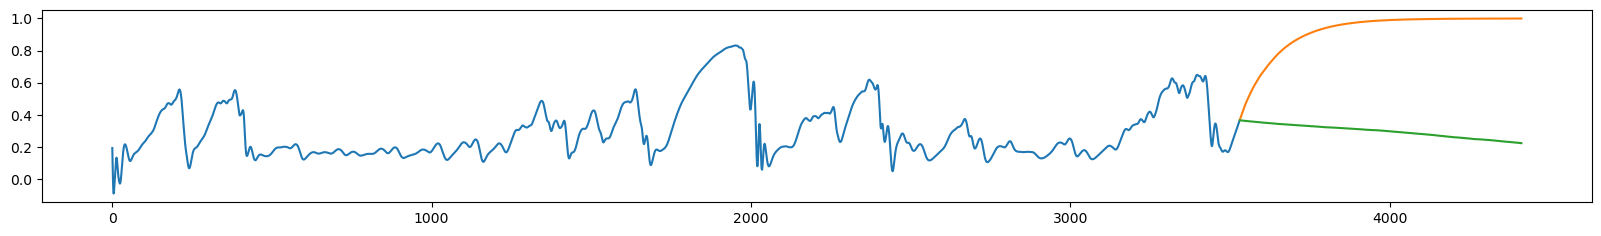

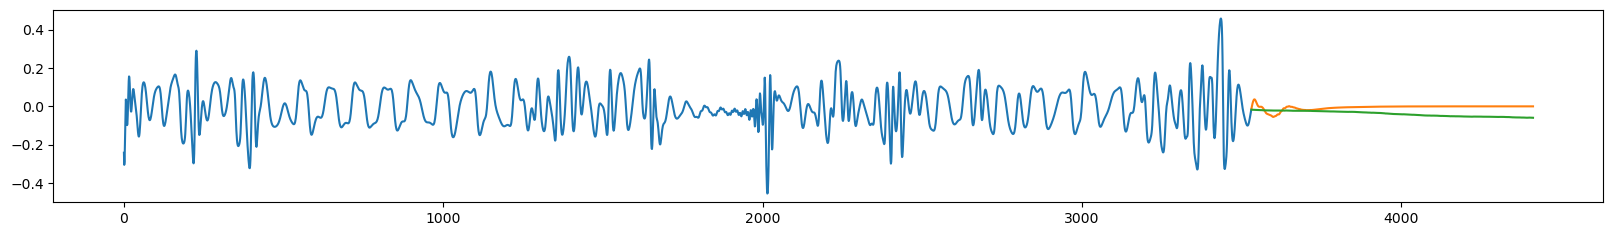

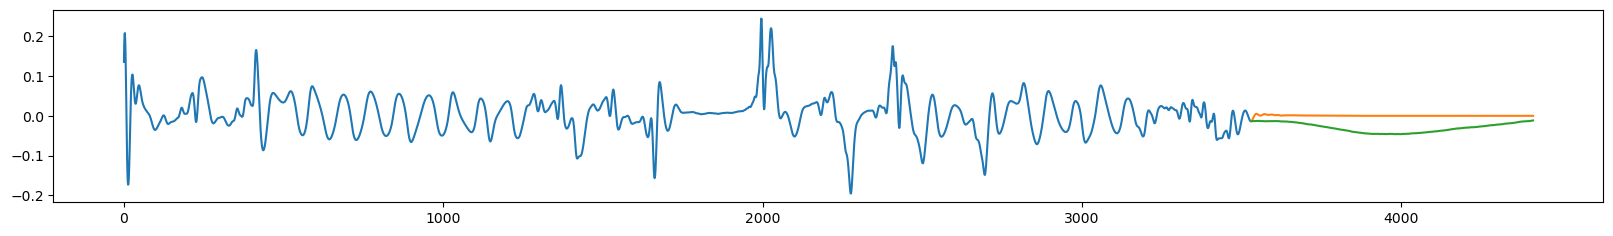

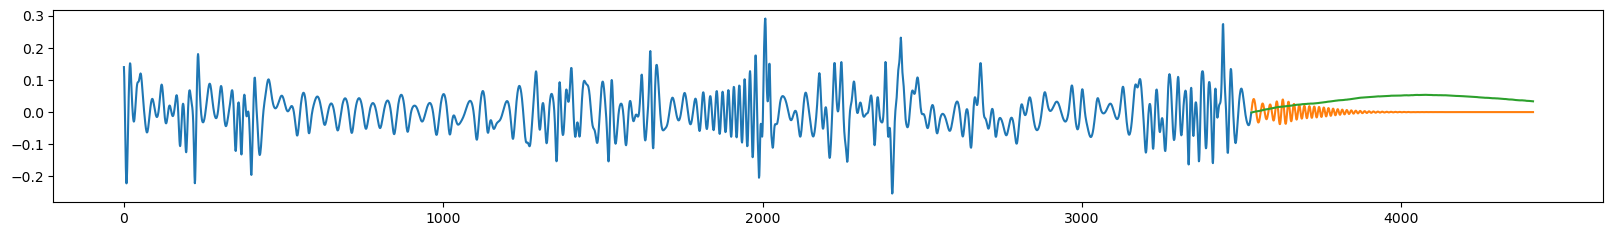

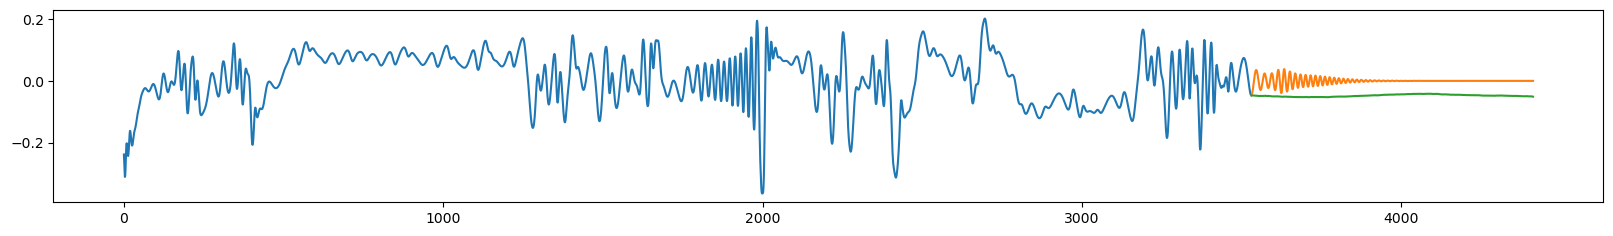

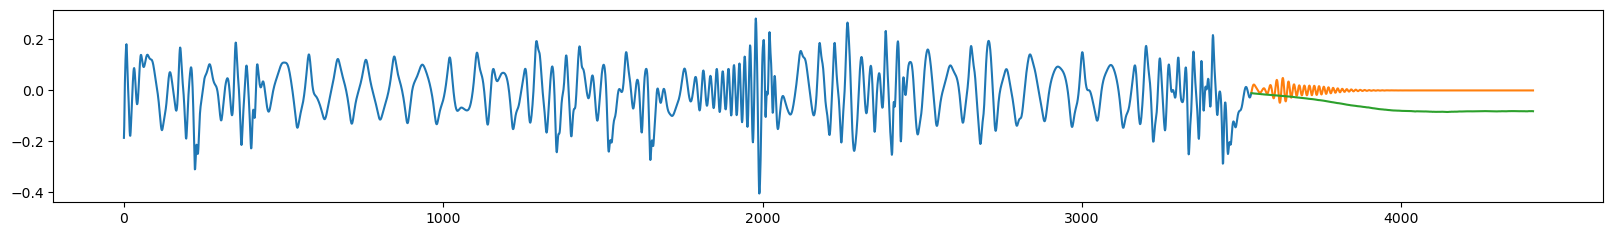

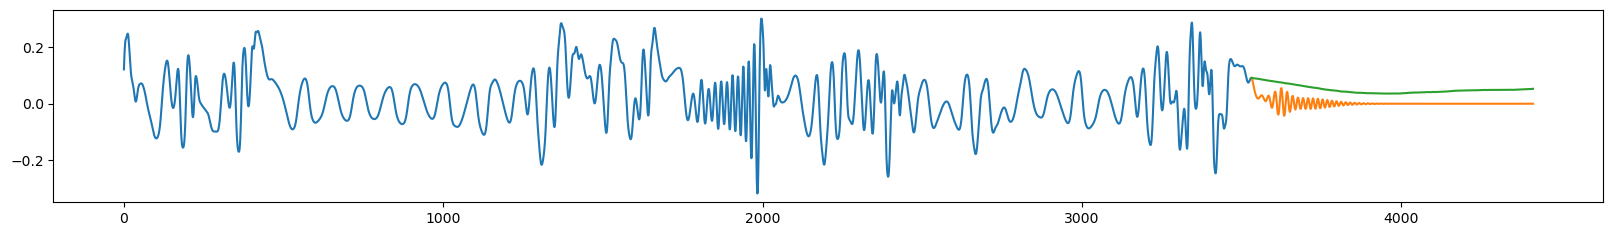

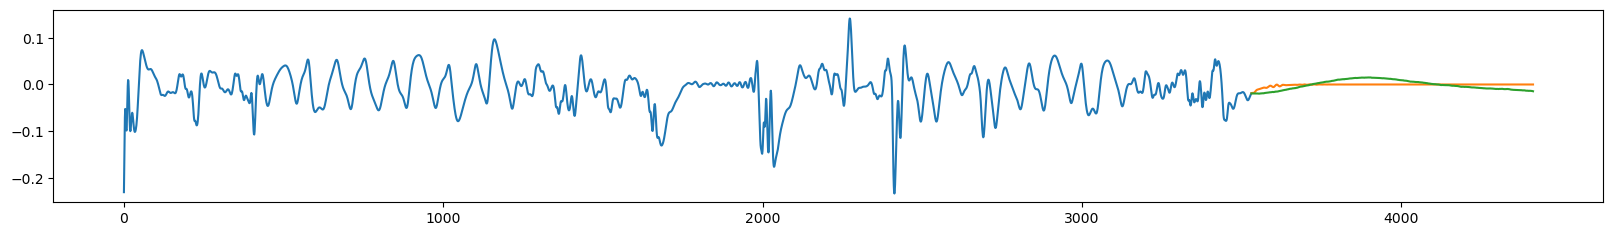

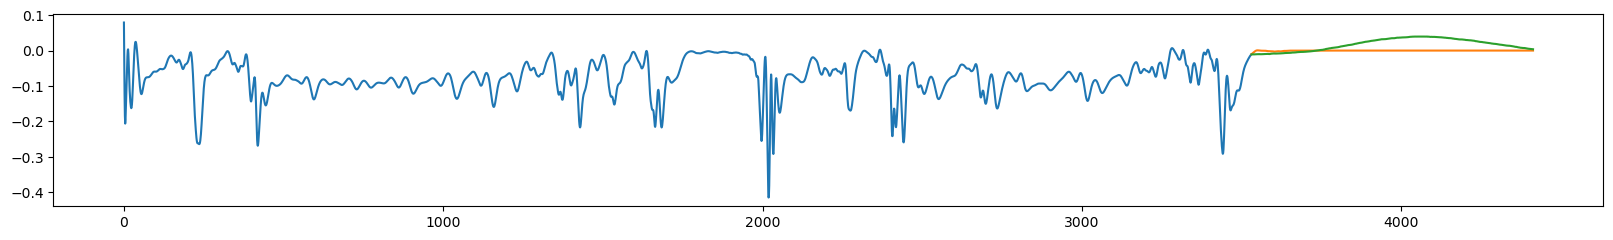

In [73]:
pred = esn.predict(t_test)

for i in range(9):
    plt.figure(figsize=(20,2.5))
    plt.plot(t_train, a_train[:, i])
    plt.plot(t_test, a_test[:, i])
    plt.plot(t_test, pred[:, i])

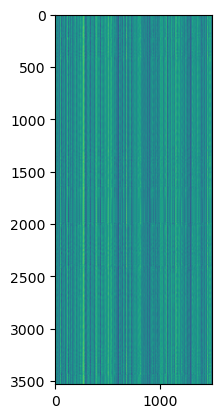

In [66]:
plt.imshow(esn.R)

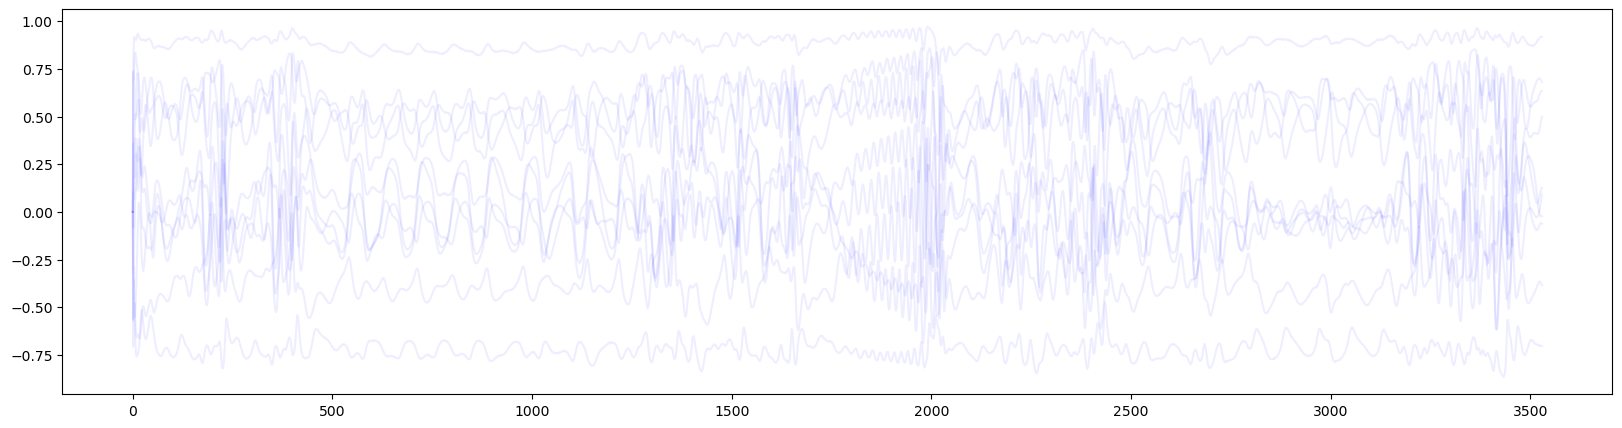

In [67]:
plt.figure(figsize=(20,5))
plt.plot(esn.R[:, :10], color="#0000ff11");